Analysis the results under new code

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number

from joblib import Parallel, delayed

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2
from IPython.display import display
import pandas as pd
from collections import defaultdict as ddict



In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT

from utils.misc import save_pkl, load_pkl, get_local_min_idxs
from scenarios.real_simu_logi import settings
from scenarios.real_simu_logi_meg import settings as settingms


In [5]:
import logging
from optimization.opt import logger as logger1
logger1.handlers[0].setLevel(logging.WARNING)

plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_dtype(torch.float64)

In [6]:
def _get_min_idx(x):
    """Get the index of the minimal values among the local minimals.
       If there are multiple ones, return the largest index
       args:
           x: a vec
        
    """
    x = np.array(x)
    lmin_idxs = get_local_min_idxs(x);
    if len(lmin_idxs) == 0:
        lmin_idxs = np.arange(len(x))
    lmin_idxs_inv =  lmin_idxs[::-1]
    lmins_inv = x[lmin_idxs_inv];
    return  lmin_idxs_inv[np.argmin(lmins_inv)]
def outlier_det(T_vs, ratio_tol=0.05):
    """
    Detects outliers in a given dataset using the interquartile range (IQR) method.

    Parameters:
    - T_vs (array-like): The input dataset.
    - ratio_tol (float, optional): The tolerance ratio for outlier removal. Default is 0.05.

    Returns:
    - kpidx (ndarray): A boolean array indicating whether each data point is an outlier or not.
    """
    Q1, Q3 = np.quantile(T_vs, [0.25, 0.75])
    IQR = Q3 - Q1
    upbd = Q3 + 1.5*IQR
    lowbd = Q1 - 1.5*IQR
    kpidx = np.bitwise_and(T_vs>=lowbd, T_vs<=upbd)
    
    if np.mean(kpidx)+ ratio_tol < 1:
        out_part = np.stack([T_vs - upbd, lowbd - T_vs]).T.max(axis=1);
        kpidx = np.ones(len(T_vs), dtype=bool)
        kpidx[np.argsort(-out_part)[:int(len(T_vs)*ratio_tol)]] = False
    return kpidx

In [7]:
def outlier_det1(T_vs, ratio_tol=0.05):
    maes = np.abs(T_vs - np.median(T_vs));
    idxs = np.argsort(-maes)
    kpidx = np.ones(len(T_vs), dtype=bool)
    kpidx[idxs[:int(ratio_tol*len(T_vs))]] = False
    return kpidx

In [74]:
opt_lamNs = {
"nm1" : {"0.0": (6, 0.2), "0.1": (6, 0.2), "0.2": (6, 0.2), "0.4": (6, 0.2)}, 
"nm1a": {"0.0": (12, 0.2), "0.1": (12, 0.2), "0.2": (12, 0.2), "0.4": (12, 0.2)}, 
"nm2" : {"0.0": (6, 0.2), "0.1": (6, 0.2), "0.2": (6, 0.2), "0.4": (6, 0.2)}, 
"nm2a": {"0.0": (8, 0.2), "0.1": (8, 0.2), "0.2": (8, 0.2), "0.4": (8, 0.2)}, 
}


{'nm1': {'0.0': (6, 0.2), '0.1': (6, 0.2), '0.2': (6, 0.2), '0.4': (6, 0.2)},
 'nm1a': {'0.0': (12, 0.2),
  '0.1': (12, 0.2),
  '0.2': (12, 0.2),
  '0.4': (12, 0.2)},
 'nm2': {'0.0': (6, 0.2), '0.1': (6, 0.2), '0.2': (6, 0.2), '0.4': (6, 0.2)},
 'nm2a': {'0.0': (8, 0.2), '0.1': (8, 0.2), '0.2': (8, 0.2), '0.4': (8, 0.2)}}

In [28]:
opt_lamNs = {
"n1" : {"0.0": ( 6, 0.2), "0.1": ( 6, 0.2), "0.2": ( 6, 0.2), "0.4": ( 6, 0.2)}, # CV for N and lam, both entropy or AUC
"n1a": {"0.0": (12, 0.2), "0.1": (12, 0.2), "0.2": (12, 0.2), "0.4": (12, 0.2)}, # CV for N and lam, both entropy or AUC
"n2" : {"0.0": ( 6, 0.3), "0.1": ( 6, 0.3), "0.2": ( 6, 0.3), "0.4": ( 6, 0.3)}, # CV for N and lam, for entropy 
"n2a": {"0.0": ( 6, 0.1), "0.1": ( 6, 0.1), "0.2": ( 6, 0.1), "0.4": ( 6, 0.1)}, # CV for N and lam, both entropy or AUC
}

{'n1': {'0.0': (6, 0.2), '0.1': (6, 0.2), '0.2': (6, 0.2), '0.4': (6, 0.2)},
 'n1a': {'0.0': (12, 0.2),
  '0.1': (12, 0.2),
  '0.2': (12, 0.2),
  '0.4': (12, 0.2)},
 'n2': {'0.0': (6, 0.3), '0.1': (6, 0.3), '0.2': (6, 0.3), '0.4': (6, 0.3)},
 'n2a': {'0.0': (6, 0.1), '0.1': (6, 0.1), '0.2': (6, 0.1), '0.4': (6, 0.1)}}

In [29]:
num_rep0 = 200;
num_rep1 = 1000;
setting = settings["n1a"]
#setting = settingms["nm2"]
can_Ns = setting.can_Ns
can_lams = setting.can_lams
print(can_lams)

c1s = [0.0, 0.1, 0.2, 0.4]
Cmat = np.eye(1) 
#Cmat = np.array([
#    [1, -1], 
#    #[1, -0.8], 
#    #[2, -1.5], 
#]).reshape(1, -1)
#Cmat = np.array([
#    [0.5, 1.5, -5], 
#    #[1.5, -1, 0], 
#    #[4, -1.2, -0.8], 
#])

[0.001, 0.05, 0.1, 0.2, 0.3, 2.0, 4.0, 16.0]


array([[1.]])

In [38]:
# get GT at c=0
ts = setting.data_gen_params.beta_fn(setting.data_gen_params.cs_fn(0.2))[:, :Cmat.shape[-1]]
ts = ts @ Cmat.T;
np.linalg.norm(ts)

5.949434263164383

In [39]:
if False:
    def _run_fn1(seed, all_cv_errs):
        errs_mat = []
        for cur_N in can_Ns:
            errs = []
            for cur_lam in can_lams:
                errs.append(all_cv_errs[(seed, cur_N, cur_lam)].entropy_loss)
            errs_mat.append(errs)
        errs_mat = np.array(errs_mat)
        return errs_mat
    opt_lamNs_fix = {}
    for c1 in c1s:
        cur_save_dir = RES_ROOT/f"simu_logi_setting{setting.setting}_{c1*1000:.0f}"
        all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics.pkl")
        num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
        # do not make n_jobs>1, it is very slow
        with Parallel(n_jobs=1) as parallel:
            err_ten = parallel(delayed(_run_fn1)(cur_seed, all_cv_errs)  
                                     for cur_seed in tqdm(range(num_seed), total=num_seed, desc=f"c1: {c1}"))
        err_ten = np.array(err_ten);
        
        err_ten_ses = err_ten.std(axis=0)/np.sqrt(err_ten.shape[0])
        err_m = np.median(np.array(err_ten), axis=0)
        errs = []
        for err in err_m:
            lam_min_idx = _get_min_idx(err)
            errs.append((err[lam_min_idx], lam_min_idx))
        errs = np.array(errs)
        N_min_idx = np.argmin(errs[:, 0]);
        lam_min_idx = int(errs[N_min_idx][1]);
        min_opt_N, min_opt_lam = can_Ns[N_min_idx], can_lams[lam_min_idx]
        
        err_upbd = err_m[N_min_idx, lam_min_idx] + err_ten_ses[N_min_idx, lam_min_idx]; 
        lam_1se_idx = np.where(err_m[N_min_idx] <= err_upbd)[0].max();
        print(can_Ns[N_min_idx], can_lams[lam_min_idx], can_lams[lam_1se_idx])
        opt_lamNs_fix[c1] = (can_Ns[N_min_idx],  can_lams[lam_min_idx])
else:
    opt_lamNs_fix = opt_lamNs[setting.setting]   
    
ress_dict = {}
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_logi_setting{setting.setting}_{c1*1000:.0f}"
    if c1 in opt_lamNs_fix.keys():
        cur_N, cur_lam = opt_lamNs_fix[c1]
    else:
        cur_N, cur_lam = opt_lamNs_fix[str(c1)]
    print(c1, cur_N, cur_lam)
    def _run_fn_test(cur_seed):
        from optimization.opt import logger as logger1
        logger1.handlers[0].setLevel(logging.WARNING)
        torch.set_default_dtype(torch.float64)
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}_fit.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        res1.basis_mat = torch.tensor(res1.obt_bsp(np.linspace(0, 1, setting.data_gen_params.npts), 
                                      res1.bsp_params.N, res1.bsp_params.basis_ord)).to(torch.get_default_dtype());
        res = res1.hypo_test(Cmat=Cmat, ts=ts, is_simpler=False, hypo_params={"svdinv_eps_Q": 1e-7, "svdinv_eps_Psi": 1e-7}) 
    
        return res 
    with Parallel(n_jobs=10) as parallel:
        ress = parallel(delayed(_run_fn_test)(cur_seed) for cur_seed in tqdm(range(num_rep1), desc=f"c1: {c1*1000:.0f}", total=num_rep1))
    ress = np.array(ress);
    ress_dict[c1] = ress

0.0 12 0.2


c1: 0: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 548.79it/s]


0.1 12 0.2


c1: 100: 100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 624.61it/s]


0.2 12 0.2


c1: 200: 100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 617.66it/s]


0.4 12 0.2


c1: 400: 100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 444.54it/s]


In [40]:
out_res = ddict(list)
for c1 in c1s:
    ress = ress_dict[c1][:]
    pvals = np.array([res["pval"] for res in ress]);
    T_vs = np.array([res["T_v"].item() for res in ress]);
    kpidx = outlier_det1(T_vs, 0.05)
    out_res["pval"].append(np.mean(pvals[kpidx]<0.05))
    out_res["T_vs"].append(np.mean(T_vs[kpidx]))

out_res["c"] = c1s
pd.DataFrame(out_res)

,pval,T_vs,c
0,0.658947,25.428179,0.0
1,0.169474,15.219328,0.1
2,0.058947,12.605039,0.2
3,0.449474,20.523502,0.4


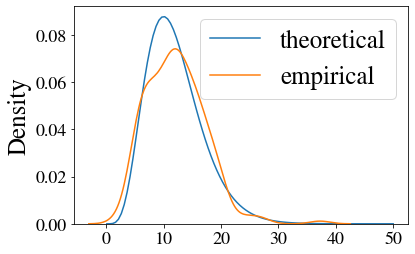

In [67]:
ress = ress_dict[0.0][:]
pvals = np.array([res["pval"] for res in ress]);
T_vs = np.array([res["T_v"].item() for res in ress]);
kpidx = outlier_det(T_vs, 0.05);
chi_df = Cmat.shape[0]*12

xs = np.linspace(0.1, 50, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
sns.kdeplot(T_vs, label="empirical")
#sns.kdeplot(T_vs[kpidx], label="empirical(no)")
plt.legend()

# Test

In [31]:
num_rep0 = 200;
num_rep1 = 1000;
setting = settings["n1"]
setting = settingms["nm2"]
can_Ns = setting.can_Ns
can_lams = setting.can_lams

c1s = [0.0, 0.2, 0.4]

Cmat = np.array([
    [1, -1], 
])
# get GT at c=0
ts = setting.data_gen_params.beta_fn(setting.data_gen_params.cs_fn(0.0))[:, :Cmat.shape[-1]]
ts = ts @ Cmat.T;

In [50]:
from hdf_utils.likelihood import obt_lin_tm
from utils.functions import logit_fn
    
ress_dict = {}
c1 = 0.0
cur_save_dir = RES_ROOT/f"simu_logi_setting{setting.setting}_{c1*1000:.0f}"
cur_N, cur_lam = 6, 0.4
def _run_fn_test(cur_seed):
    from optimization.opt import logger as logger1
    logger1.handlers[0].setLevel(logging.WARNING)
    torch.set_default_dtype(torch.float64)
    f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}_fit.pkl"
    res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
    res1.basis_mat = torch.tensor(res1.obt_bsp(np.linspace(0, 1, setting.data_gen_params.npts), 
                                  res1.bsp_params.N, res1.bsp_params.basis_ord)).to(torch.get_default_dtype());
    res = edict()
    #res = res1.hypo_test(Cmat=Cmat, ts=ts, is_simpler=False, hypo_params={"svdinv_eps_Q": 1e-7, "svdinv_eps_Psi": 1e-7}) 
    #res.est_lintm = obt_lin_tm(hdf.Z, hdf.X[:, hdf.keep_idxs], hdf.est_alp, hdf.est_Gam, hdf.basis_mat).numpy()
    #res.est_prob = logit_fn(res.est_lintm)
    #res.cv_Y_est = res1.cv_Y_est
    #res.Y = res1.Y.numpy()
    res.est_alp = res1.est_alp
    res.est_Gam = res1.est_Gam
    res.keep_idxs = res1.keep_idxs

    return res
with Parallel(n_jobs=10) as parallel:
    ress = parallel(delayed(_run_fn_test)(cur_seed) for cur_seed in tqdm(range(num_rep0), desc=f"c1: {c1*1000:.0f}", total=num_rep0))
ress = np.array(ress);

c1: 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 527.10it/s]


In [51]:
np.mean([res["est_alp"].numpy() for res in ress], axis=0)

array([-0.29420922, -0.47728507,  0.96075412])

In [90]:
from utils.misc import bcross_entropy_loss, bcross_entropy_loss_truc
T_vs = np.array([res.T_v.numpy() for res in ress]);
pvals = np.array([res["pval"] for res in ress]);
#errs1 = -np.array([np.quantile(res.cv_Y_est, [0.90])[0] for res in ress]);
errs1 = 1-np.array([np.quantile(res.est_prob, [0.90])[0] for res in ress]);
errs2  = np.array([np.quantile(res.est_prob, [0.10])[0] for res in ress]);
errs2 = np.array([bcross_entropy_loss(res.est_prob,res.Y) for res in ress]);
#errs = -np.array([np.quantile(res.est_lintm[res.Y==1], [0.90])[0] for res in ress]);
#errs = np.array([np.quantile(res.est_lintm[res.Y==0], [0.10])[0] for res in ress]);
#errs = np.array([bcross_entropy_loss(res.cv_Y_est,res.Y.numpy()) for res in ress]);
#errs = -np.array([np.quantile(res.cv_Y_est[res.Y.numpy()==1], [0.9])[0] for res in ress]);
#errs = np.array([np.quantile(res.cv_Y_est[res.Y.numpy()==0], [0.2])[0] for res in ress]);

plt.plot(T_vs, errs2, ".")
#plt.yscale("log")

AttributeError: 'EasyDict' object has no attribute 'est_prob'

In [608]:
def _get_kpidx(errs):
    kpidx = np.ones_like(T_vs, dtype=bool)
    rmidx = np.argsort(errs)[:50]
    #rmidx = np.where(errs < 5e-3)
    kpidx[rmidx] = False
    return kpidx
kpidx1 = _get_kpidx(errs1)
kpidx2 = _get_kpidx(errs2)
kpidx = np.bitwise_or(kpidx1, kpidx2);
kpidx = kpidx2
#kpidx = outlier_det(T_vs, 0.05)
np.mean(kpidx)

0.75

In [609]:
np.mean(pvals[kpidx]<0.05), np.mean(pvals<0.05)

(0.06, 0.095)

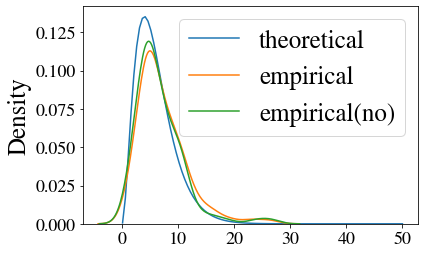

In [610]:
chi_df = Cmat.shape[0]*6

xs = np.linspace(0.1, 50, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
sns.kdeplot(T_vs, label="empirical")
sns.kdeplot(T_vs[kpidx], label="empirical(no)")
plt.legend()